In [39]:
import sqlalchemy as sa
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from dotenv import dotenv_values
import os

ENV_FILE='.env' # <- CHANGE THIS TO PLOT YOUR CONFIGURATION
dotenv_path = os.path.join('.env')
config = dotenv_values(dotenv_path)

IP=config['DB_HOST']
PORT=config['DB_PORT']
DATABASE=config['DB_NAME']
USER=config['DB_USER']
PASSWORD=config['DB_PASSWD']

URL = f'postgresql://{USER}:{PASSWORD}@{IP}:{PORT}/{DATABASE}'

engine = sa.create_engine(URL)
conn = engine.connect()


# --- Test stuff ---

In [40]:
# Configuration
init_date = '2023-06-16 00:00:00'
finish_date = '2023-07-16 00:00:00'

In [41]:
# get number of available nodes between dates
query = f"""
select 
    cid_hash,
    pub_time
from cid_info
where pub_time > '{init_date}' and pub_time < '{finish_date}'
order by pub_time ASC;
"""

df = pd.read_sql_query(sa.text(query), conn)
display(df)

,cid_hash,pub_time
0,QmNhi3wVJ2A8qkziaA1UshKuGk6hNJkgervGGEUippBPua,2023-06-16 09:13:43.442304
1,QmQZYAMom3Bu4TgDyaVZvZE95d9Q1GTzvsJKjR7c5jPmo3,2023-06-16 09:13:43.442314
2,QmdtWSA7ocB52E7EzQFviaJkZwtVfCW28hiAoYjTG1Fc1Z,2023-06-16 09:13:43.442442
3,QmYSFqvT3TqoCnKx4ceB8ipifEjwCSFN2Pnv7zw5HueNC6,2023-06-16 09:15:13.442730
4,QmQQDh3F4gxKka1Uov7wGVCWzsQyR3PURBFzVysj1no6ip,2023-06-16 09:15:13.442772
...,...,...
85285,QmPiJQswEdqEnM7fwxzi23QrWeVfFV7QUsATVdf2tf3VDH,2023-07-15 23:58:08.208879
85286,QmYrhJpqhTAcDcc7ej2ZvpaLgu8CopDGTSWJvbTVknjeyG,2023-07-15 23:58:24.844097
85287,QmfDqxpHNAES2ykXDCHhNxSEU9WDBcr9PLi2wXqsNJrLnx,2023-07-15 23:59:37.883897
85288,QmZYPzDNmQgkeNc6gY7y1jZgeKC2EmP2fFUNqi9BpRs1DH,2023-07-15 23:59:38.209023


query done in 8.327677965164185 seconds


,cid_hash,pub_time,rounds
0,QmTQfnrugw4aaCpskRzoTbeVuenNUievTkCaqUzv5FEMN5,2023-07-06 00:38:05.321395,97
1,QmNLfity4nFv8zxCPQMDbGCYs2FihcMTRGqZGd9yC2g5sL,2023-06-21 22:10:45.630108,97
2,QmNLgD8B14rMxLNd7LS8AAH7uKqoQgETQzkijpFmA5gsHb,2023-07-02 16:15:33.929817,97
3,QmNLgf4U5ihz6UPrFJ17epspzJv8dVYEKoPtGaWKXsTdtd,2023-07-07 05:50:05.882165,97
4,QmNLgsMVeMaL7iK5kuDmsiFVsM6zT344J4FNRw9Jk2hCYa,2023-06-30 07:26:03.023765,97
...,...,...,...
85285,QmY8vBUkW1Mpbcqx3Kgs1cyBia2atoEewrehhd65aEAqwB,2023-06-24 19:39:16.713628,1
85286,QmTrUyUwdC8adreUW8BwiWbCaAiqp8EuVPqo91pqf7Vj3m,2023-06-24 19:16:46.709392,1
85287,QmVQpbwqrWFyfsw5Sy3wwjo3JBnThg1j3YNWmBE94tdRqp,2023-06-24 19:13:46.713158,1
85288,QmWumar2fSzfMr7chVpywBWEJ4nvTrfQxZBMsF5jn3tRnA,2023-06-24 19:19:46.713290,1


,rounds,cid_hash,pub_time
0,1,61,61
1,2,59,59
2,3,59,59
3,4,62,62
4,5,60,60
...,...,...,...
92,93,60,60
93,94,60,60
94,95,61,61
95,96,59,59


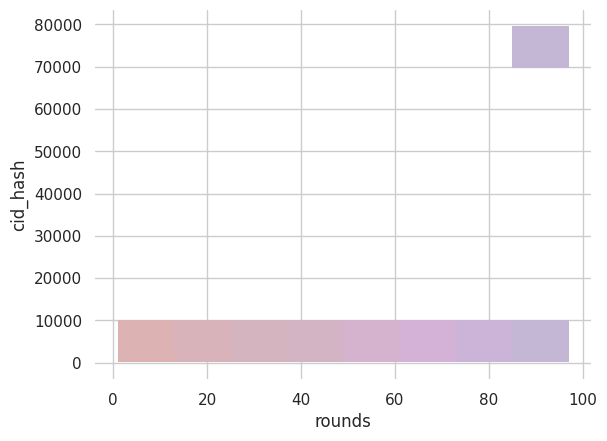

In [42]:
# get count of rounds per cid
base_query = f"""
select 
    valid_cids.cid_hash,
    valid_cids.pub_time,
    count(valid_cids.cid_hash) as rounds
from (
    select 
        cid_hash,
        pub_time
    from cid_info
    where pub_time > '{init_date}' and pub_time < '{finish_date}'
    order by pub_time ASC
) as valid_cids 
right join fetch_results on fetch_results.cid_hash = valid_cids.cid_hash
where valid_cids.cid_hash IS NOT NULL 
group by valid_cids.cid_hash, pub_time
order by rounds DESC;    
"""
start = time.time()
df = pd.read_sql_query(sa.text(base_query), conn)
print(f"query done in {time.time()-start} seconds")
display(df)

# data proc
df = df.groupby('rounds').count().reset_index()
display(df)

sns.set_style("whitegrid")
g = sns.histplot(data=df, x='rounds', y='cid_hash', hue='rounds')
sns.despine(left=True, bottom=True)
g.get_legend().set_visible(False)
plt.show()


query done in 0.43109965324401855 seconds


,cid_hash,pub_time,rounds
0,QmTmGnrUfdnnRBkGJZqXft4XE1SPcoix9dreF9s5iVCKdC,2023-06-22 08:40:45.798485,97
1,QmNLfity4nFv8zxCPQMDbGCYs2FihcMTRGqZGd9yC2g5sL,2023-06-21 22:10:45.630108,97
2,QmNLgD8B14rMxLNd7LS8AAH7uKqoQgETQzkijpFmA5gsHb,2023-07-02 16:15:33.929817,97
3,QmNLgf4U5ihz6UPrFJ17epspzJv8dVYEKoPtGaWKXsTdtd,2023-07-07 05:50:05.882165,97
4,QmNLgsMVeMaL7iK5kuDmsiFVsM6zT344J4FNRw9Jk2hCYa,2023-06-30 07:26:03.023765,97
...,...,...,...
79645,QmVQojmu7DcqTKbFasUNbKKynJV7n31zjL6NESCjNFipn6,2023-06-22 20:30:15.975822,95
79646,QmfSreqeYA4F5v2hcnnnkJaFPZkCQA5tjctzrarxqZRyBC,2023-06-22 20:40:45.981467,95
79647,QmfGZoahab8cpgXmasSZRpvQgBHB7FXjmb7b66UKbw3taj,2023-06-22 20:16:45.976215,95
79648,QmfW9CFtHSBXGzgN2wxmQQFUNX9LAZeoCoSNxGMP3Y7PkV,2023-06-22 20:43:45.978786,95


,date,cid_hash,pub_time,rounds
0,06/16,1773,1773,1773
1,06/17,2880,2880,2880
2,06/18,2880,2880,2880
3,06/19,2880,2880,2880
4,06/20,2880,2880,2880
5,06/21,2880,2880,2880
6,06/22,2490,2490,2490
7,06/24,507,507,507
8,06/25,2880,2880,2880
9,06/26,2880,2880,2880


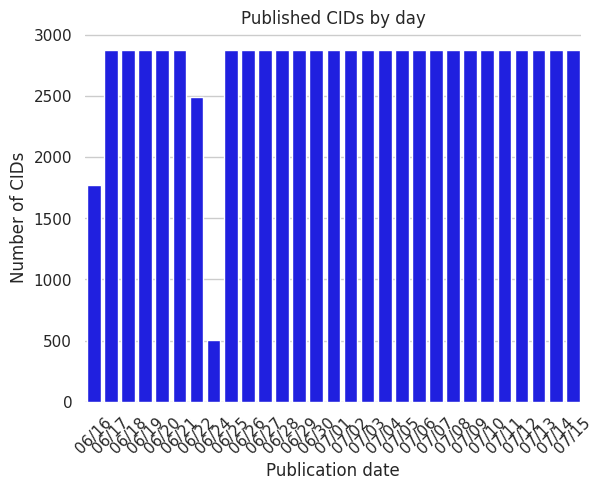

In [43]:
# Published CIDs per Day
base_query = f"""
select 
    cid_hash,
    pub_time,
    rounds
from valid_cid_mv v
where pub_time > '{init_date}' and pub_time < '{finish_date}'
order by rounds DESC;    
"""
start = time.time()
df = pd.read_sql_query(sa.text(base_query), conn)
print(f"query done in {time.time()-start} seconds")
display(df)

# data proc
df['date'] = df['pub_time'].dt.strftime('%m/%d')
df = df.groupby(['date']).count().reset_index()
display(df)
sns.set_style("whitegrid")
g = sns.barplot(data=df, x='date', y='cid_hash', color='blue')
g.set(title="Published CIDs by day", xlabel='Publication date', ylabel='Number of CIDs')
sns.despine(left=True, bottom=True)
plt.xticks(rotation=80)
plt.show()

query done in 4.080330848693848 seconds


,cid_hash,pub_time,client,nodes
0,QmNhi3wVJ2A8qkziaA1UshKuGk6hNJkgervGGEUippBPua,2023-06-16 09:13:43.442304,Others,3
1,QmNhi3wVJ2A8qkziaA1UshKuGk6hNJkgervGGEUippBPua,2023-06-16 09:13:43.442304,go-ipfs,2
2,QmNhi3wVJ2A8qkziaA1UshKuGk6hNJkgervGGEUippBPua,2023-06-16 09:13:43.442304,kubo,15
3,QmQZYAMom3Bu4TgDyaVZvZE95d9Q1GTzvsJKjR7c5jPmo3,2023-06-16 09:13:43.442314,Others,1
4,QmQZYAMom3Bu4TgDyaVZvZE95d9Q1GTzvsJKjR7c5jPmo3,2023-06-16 09:13:43.442314,go-ipfs,2
...,...,...,...,...
216860,QmZYPzDNmQgkeNc6gY7y1jZgeKC2EmP2fFUNqi9BpRs1DH,2023-07-15 23:59:38.209023,go-ipfs,1
216861,QmZYPzDNmQgkeNc6gY7y1jZgeKC2EmP2fFUNqi9BpRs1DH,2023-07-15 23:59:38.209023,kubo,15
216862,QmY61FizGyYZWt1jpUYKdAxj2PyNKbQFMyzB7Bxj4hMTX3,2023-07-15 23:59:54.845602,Others,3
216863,QmY61FizGyYZWt1jpUYKdAxj2PyNKbQFMyzB7Bxj4hMTX3,2023-07-15 23:59:54.845602,go-ipfs,2


,date,client,nodes
0,06/16,Others,4934
1,06/16,go-ipfs,2227
2,06/16,kubo,28100
3,06/16,storm,199
4,06/17,Others,7952
...,...,...,...
113,07/14,storm,315
114,07/15,Others,7650
115,07/15,go-ipfs,3237
116,07/15,kubo,46377


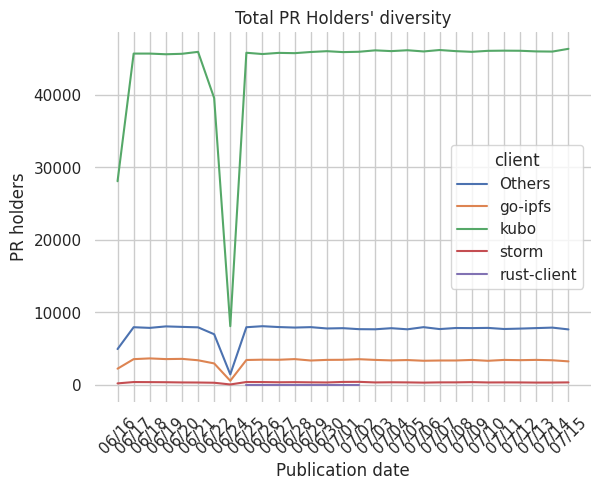

,date,client,nodes
0,06/16,Others,3.0
1,06/16,go-ipfs,1.0
2,06/16,kubo,16.0
3,06/16,storm,1.0
4,06/17,Others,3.0
...,...,...,...
113,07/14,storm,1.0
114,07/15,Others,3.0
115,07/15,go-ipfs,1.0
116,07/15,kubo,16.0


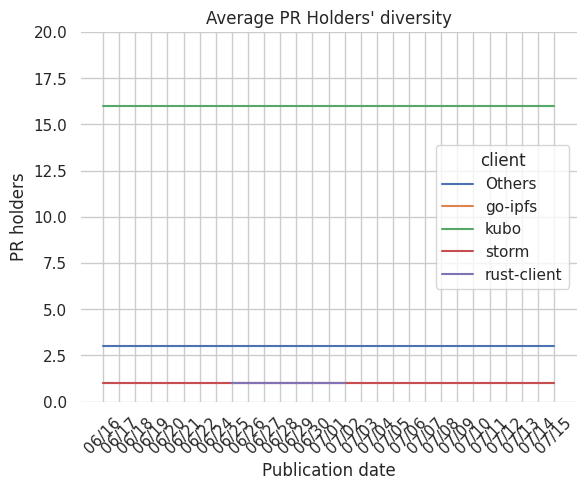

In [44]:
# Client diversity of the published CIDs
base_query = f"""
select 
    og.cid_hash,
    og.pub_time,
    pi.client,
    count(pi.client) as nodes
from (
    select
        v.cid_hash,
        v.pub_time,
        ph.peer_id    
    from valid_cid_mv v
    left join pr_holders ph on v.cid_hash = ph.cid_hash
    where v.pub_time > '{init_date}' and v.pub_time < '{finish_date}' 
) as og    
left join peer_info pi on og.peer_id = pi.peer_id
group by og.cid_hash, og.pub_time, pi.client
order by og.pub_time ASC;
"""
start = time.time()
df = pd.read_sql_query(sa.text(base_query), conn)
print(f"query done in {time.time()-start} seconds")
display(df)

# data proc
df['date'] = df['pub_time'].dt.strftime('%m/%d')
df = df.drop(columns=['cid_hash', 'pub_time'])

# Total numbers
crawl_diversity = df.groupby(['date', 'client']).sum().reset_index()
display(crawl_diversity)
sns.set_style("whitegrid")
g = sns.lineplot(data=crawl_diversity, x='date', y='nodes', hue='client')
g.set(title="Total PR Holders' diversity", xlabel='Publication date', ylabel='PR holders')
sns.despine(left=True, bottom=True)
plt.xticks(rotation=45)
plt.show()

# mean values
mean_pr_holders = df.groupby(['date', 'client']).median().reset_index()
display(mean_pr_holders)
sns.set_style("whitegrid")
g = sns.lineplot(data=mean_pr_holders, x='date', y='nodes', hue='client')
plt.ylim(0,20)
g.set(title="Average PR Holders' diversity", xlabel='Publication date', ylabel='PR holders')
sns.despine(left=True, bottom=True)
plt.xticks(rotation=80)
plt.show()

query done in 1.0597338676452637 seconds


,cid_hash,pub_time,success_att,fail_att,date
0,QmNhi3wVJ2A8qkziaA1UshKuGk6hNJkgervGGEUippBPua,2023-06-16 09:13:43.442304,17,3,06/16
1,QmQZYAMom3Bu4TgDyaVZvZE95d9Q1GTzvsJKjR7c5jPmo3,2023-06-16 09:13:43.442314,19,1,06/16
2,QmdtWSA7ocB52E7EzQFviaJkZwtVfCW28hiAoYjTG1Fc1Z,2023-06-16 09:13:43.442442,18,2,06/16
3,QmYSFqvT3TqoCnKx4ceB8ipifEjwCSFN2Pnv7zw5HueNC6,2023-06-16 09:15:13.442730,13,7,06/16
4,QmQQDh3F4gxKka1Uov7wGVCWzsQyR3PURBFzVysj1no6ip,2023-06-16 09:15:13.442772,17,3,06/16
...,...,...,...,...,...
79645,QmPiJQswEdqEnM7fwxzi23QrWeVfFV7QUsATVdf2tf3VDH,2023-07-15 23:58:08.208879,18,2,07/15
79646,QmYrhJpqhTAcDcc7ej2ZvpaLgu8CopDGTSWJvbTVknjeyG,2023-07-15 23:58:24.844097,18,2,07/15
79647,QmfDqxpHNAES2ykXDCHhNxSEU9WDBcr9PLi2wXqsNJrLnx,2023-07-15 23:59:37.883897,16,4,07/15
79648,QmZYPzDNmQgkeNc6gY7y1jZgeKC2EmP2fFUNqi9BpRs1DH,2023-07-15 23:59:38.209023,16,4,07/15


,date,pub_time,success_att,fail_att
0,06/16,2023-06-16 16:36:13.593494016,17.0,3.0
1,06/17,2023-06-17 11:59:28.946878976,17.0,3.0
2,06/18,2023-06-18 11:59:29.334393344,18.0,2.0
3,06/19,2023-06-19 11:59:29.718603776,17.0,3.0
4,06/20,2023-06-20 11:59:30.081113088,18.0,2.0
5,06/21,2023-06-21 11:59:30.472165888,18.0,2.0
6,06/22,2023-06-22 10:22:00.825641472,17.0,3.0
7,06/24,2023-06-24 21:53:00.965777920,17.0,3.0
8,06/25,2023-06-25 11:59:46.244062464,18.0,2.0
9,06/26,2023-06-26 11:59:46.690175488,18.0,2.0


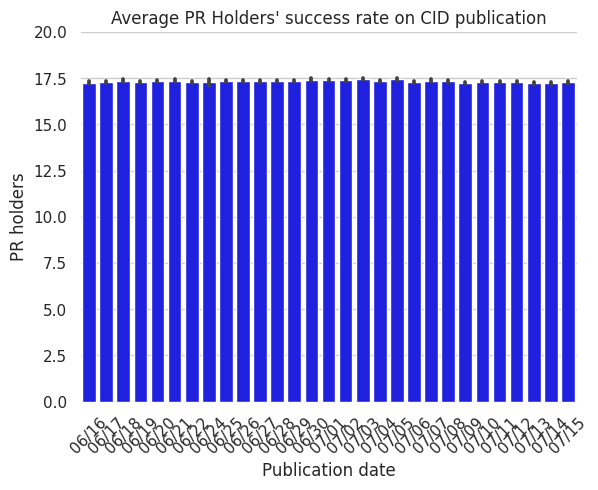

In [45]:
# CID publication's effectiveness
base_query = f"""
select
    v.cid_hash,
    v.pub_time,
    fr.success_att, 
    fr.fail_att
from valid_cid_mv v
left join fetch_results fr on v.cid_hash = fr.cid_hash 
where v.pub_time > '{init_date}' and v.pub_time < '{finish_date}' and fr.ping_round = 0 
order by v.pub_time ASC;
"""

start = time.time()
df = pd.read_sql_query(sa.text(base_query), conn)
print(f"query done in {time.time()-start} seconds")

# data proc
df['date'] = df['pub_time'].dt.strftime('%m/%d')
display(df)
df = df.drop(columns=['cid_hash'])

# mean values
mean_succ_provides = df.groupby(['date']).median().reset_index()
# mean_succ_provides = pd.melt(mean_succ_provides, id_vars=['date'], value_vars=['success_att', 'fail_att'], var_name='status')
display(mean_succ_provides)
sns.set_style("whitegrid")
g = sns.barplot(data=df, x='date', y='success_att', color='blue')
plt.ylim(0,20)
plt.title("Average PR Holders' success rate on CID publication")
plt.xlabel('Publication date')
plt.ylabel('PR holders')
sns.despine(left=True, bottom=True)
plt.xticks(rotation=90)
plt.show()


query done in 0.851515531539917 seconds


,cid_hash,pub_time,provide_time_ms,date,prov_time
0,QmNhi3wVJ2A8qkziaA1UshKuGk6hNJkgervGGEUippBPua,2023-06-16 09:13:43.442304,4459.0,06/16,4.459
1,QmQZYAMom3Bu4TgDyaVZvZE95d9Q1GTzvsJKjR7c5jPmo3,2023-06-16 09:13:43.442314,10064.0,06/16,10.064
2,QmdtWSA7ocB52E7EzQFviaJkZwtVfCW28hiAoYjTG1Fc1Z,2023-06-16 09:13:43.442442,7255.0,06/16,7.255
3,QmYSFqvT3TqoCnKx4ceB8ipifEjwCSFN2Pnv7zw5HueNC6,2023-06-16 09:15:13.442730,6867.0,06/16,6.867
4,QmQQDh3F4gxKka1Uov7wGVCWzsQyR3PURBFzVysj1no6ip,2023-06-16 09:15:13.442772,10161.0,06/16,10.161
...,...,...,...,...,...
79645,QmPiJQswEdqEnM7fwxzi23QrWeVfFV7QUsATVdf2tf3VDH,2023-07-15 23:58:08.208879,2592.0,07/15,2.592
79646,QmYrhJpqhTAcDcc7ej2ZvpaLgu8CopDGTSWJvbTVknjeyG,2023-07-15 23:58:24.844097,1911.0,07/15,1.911
79647,QmfDqxpHNAES2ykXDCHhNxSEU9WDBcr9PLi2wXqsNJrLnx,2023-07-15 23:59:37.883897,9834.0,07/15,9.834
79648,QmZYPzDNmQgkeNc6gY7y1jZgeKC2EmP2fFUNqi9BpRs1DH,2023-07-15 23:59:38.209023,7250.0,07/15,7.250


,date,prov_time_p25,prov_time_p50,prov_time_p75,prov_time_p90
0,06/16,4.02300,6.7420,8.96800,21.3916
1,06/17,3.92200,6.7480,9.76925,22.6814
2,06/18,3.98950,6.8070,9.63000,20.6089
3,06/19,3.79350,6.7975,9.85900,22.7262
4,06/20,3.90775,6.8285,9.60800,21.5322
5,06/21,3.59375,6.7170,9.73675,23.0705
6,06/22,3.81400,6.7895,9.70825,24.4797
7,06/24,3.06950,6.6440,8.24650,20.5562
8,06/25,3.54500,6.7250,9.90350,24.3060
9,06/26,3.48250,6.6890,9.45100,22.8972


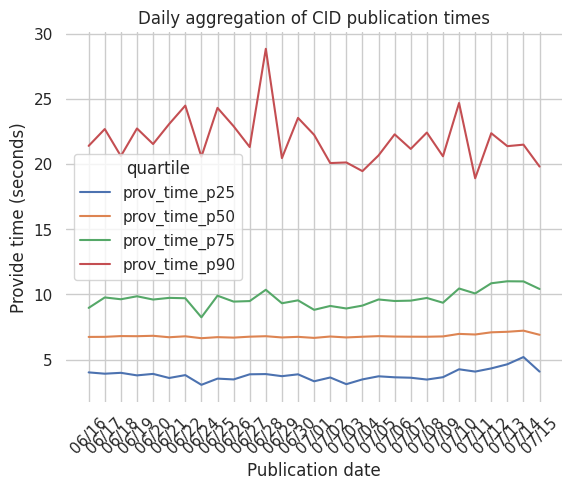

In [46]:
# Publication time
# CID publication's effectiveness
base_query = f"""
select
    v.cid_hash,
    v.pub_time,
    fr.provide_time_ms
from valid_cid_mv v
left join cid_info fr on v.cid_hash = fr.cid_hash 
where v.pub_time > '{init_date}' and v.pub_time < '{finish_date}'
order by v.pub_time ASC;
"""

start = time.time()
df = pd.read_sql_query(sa.text(base_query), conn)
print(f"query done in {time.time()-start} seconds")

# data proc
df['date'] = df['pub_time'].dt.strftime('%m/%d')
df['prov_time'] = df['provide_time_ms'] / 1000.0
display(df)

def p25(x):
    return x.quantile(0.25)
def p50(x):
    return x.quantile(0.50)
def p75(x):
    return x.quantile(0.75)
def p90(x):
    return x.quantile(0.90)

vals = {'prov_time': [p25, p50, p75, p90]}
quartiles = df.groupby('date').agg(vals)
quartiles.columns = quartiles.columns.map('_'.join)
quartiles = quartiles.reset_index()
display(quartiles)

quartiles = pd.melt(quartiles, id_vars=['date'], value_vars=['prov_time_p25', 'prov_time_p50', 'prov_time_p75', 'prov_time_p90'], var_name='quartile')

sns.set_style("whitegrid")
g = sns.lineplot(data=quartiles, x='date', y='value', hue='quartile')
g.set(title="Daily aggregation of CID publication times", xlabel='Publication date', ylabel='Provide time (seconds)')
sns.despine(left=True, bottom=True)
plt.xticks(rotation=90)
plt.show()


In [47]:
import plotly.graph_objects as go

# Check the activity of the PR holders from fetch results
query = f"""
select 
    vcm.cid_hash,
    vcm.pub_time,
    fr.ping_round,
    fr.fetch_time_since_publication_m,
    fr.success_att
from valid_cid_mv vcm
left join fetch_results fr on fr.cid_hash = vcm.cid_hash
where vcm.pub_time > '{init_date}' and vcm.pub_time < '{finish_date}'
order by vcm.pub_time, ping_round; 
"""

start = time.time()
df = pd.read_sql_query(sa.text(query), conn)
print(f"query done in {time.time()-start} seconds")

# data proc
df['date'] = df['pub_time'].dt.strftime('%m/%d')
df['since_pub_h'] = df['fetch_time_since_publication_m'].astype(int) / 60
display(df)
df = df.drop(columns=['cid_hash', 'pub_time'])

# mean values
active_nodes = df.groupby(['date', 'ping_round']).median().reset_index()
display(active_nodes)
sns.set_style("whitegrid")


query done in 54.12298083305359 seconds


,cid_hash,pub_time,ping_round,fetch_time_since_publication_m,success_att,date,since_pub_h
0,QmNhi3wVJ2A8qkziaA1UshKuGk6hNJkgervGGEUippBPua,2023-06-16 09:13:43.442304,0,3.550000e-09,17,06/16,0.000000
1,QmNhi3wVJ2A8qkziaA1UshKuGk6hNJkgervGGEUippBPua,2023-06-16 09:13:43.442304,1,3.014000e+01,20,06/16,0.500000
2,QmNhi3wVJ2A8qkziaA1UshKuGk6hNJkgervGGEUippBPua,2023-06-16 09:13:43.442304,2,6.012959e+01,20,06/16,1.000000
3,QmNhi3wVJ2A8qkziaA1UshKuGk6hNJkgervGGEUippBPua,2023-06-16 09:13:43.442304,3,9.012692e+01,20,06/16,1.500000
4,QmNhi3wVJ2A8qkziaA1UshKuGk6hNJkgervGGEUippBPua,2023-06-16 09:13:43.442304,4,1.201325e+02,20,06/16,2.000000
...,...,...,...,...,...,...,...
7725864,QmY61FizGyYZWt1jpUYKdAxj2PyNKbQFMyzB7Bxj4hMTX3,2023-07-15 23:59:54.845602,92,2.762243e+03,18,07/15,46.033333
7725865,QmY61FizGyYZWt1jpUYKdAxj2PyNKbQFMyzB7Bxj4hMTX3,2023-07-15 23:59:54.845602,93,2.792246e+03,18,07/15,46.533333
7725866,QmY61FizGyYZWt1jpUYKdAxj2PyNKbQFMyzB7Bxj4hMTX3,2023-07-15 23:59:54.845602,94,2.822243e+03,18,07/15,47.033333
7725867,QmY61FizGyYZWt1jpUYKdAxj2PyNKbQFMyzB7Bxj4hMTX3,2023-07-15 23:59:54.845602,95,2.852244e+03,18,07/15,47.533333


,date,ping_round,fetch_time_since_publication_m,success_att,since_pub_h
0,06/16,0,3.250000e-09,17.0,0.0
1,06/16,1,3.025155e+01,19.0,0.5
2,06/16,2,6.024876e+01,19.0,1.0
3,06/16,3,9.024790e+01,19.0,1.5
4,06/16,4,1.202476e+02,19.0,2.0
...,...,...,...,...,...
2808,07/15,92,2.760289e+03,19.0,46.0
2809,07/15,93,2.790281e+03,19.0,46.5
2810,07/15,94,2.820285e+03,19.0,47.0
2811,07/15,95,2.850275e+03,19.0,47.5


In [48]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Scatter3d(
    z=active_nodes['success_att'],
    x=active_nodes['date'],
    y=active_nodes['since_pub_h'],
    mode='markers',
    marker=dict(
        size=5,
        colorscale='Viridis',   # choose a colorscale
        opacity=1.,
        showscale=True,
        cmax=20,
        cmin=0),
    )])
display(fig.data[0].marker)
fig.update_layout(
    title="Average PR Holder's onlineness",
    autosize=False,
    width=900,
    height=700,
    scene = dict(
        yaxis = dict(nticks=20, range=[0, 50],),
        zaxis = dict(nticks=10, range=[0, 20],),
        xaxis_title='Date',
        yaxis_title='Hours since publication',
        zaxis_title='Online PR Holders',
    ),
    margin=dict(
        l=65,
        r=50,
        b=65,
        t=90)
    )
fig.show()


scatter3d.Marker({
    'cmax': 20,
    'cmin': 0,
    'colorscale': [[0.0, '#440154'], [0.1111111111111111, '#482878'],
                   [0.2222222222222222, '#3e4989'], [0.3333333333333333,
                   '#31688e'], [0.4444444444444444, '#26828e'],
                   [0.5555555555555556, '#1f9e89'], [0.6666666666666666,
                   '#35b779'], [0.7777777777777778, '#6ece58'],
                   [0.8888888888888888, '#b5de2b'], [1.0, '#fde725']],
    'opacity': 1.0,
    'showscale': True,
    'size': 5
})

since_pub_h,0.0,0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,...,43.5,44.0,44.5,45.0,45.5,46.0,46.5,47.0,47.5,48.0
date,,,,,,,,,,,,,,,,,,,,,
06/16,17.0,19.0,19.0,19.0,19.0,19.0,19.0,19.0,19.0,19.0,...,19.0,19.0,19.0,19.0,19.0,19.0,19.0,19.0,19.0,19.0
06/17,17.0,19.0,19.0,19.0,19.0,19.0,19.0,19.0,19.0,19.0,...,19.0,19.0,19.0,19.0,19.0,19.0,19.0,19.0,19.0,19.0
06/18,18.0,19.0,19.0,19.0,19.0,19.0,19.0,19.0,19.0,19.0,...,19.0,19.0,19.0,19.0,19.0,19.0,19.0,19.0,19.0,19.0
06/19,17.0,19.0,19.0,19.0,19.0,19.0,19.0,19.0,19.0,19.0,...,19.0,19.0,19.0,19.0,19.0,19.0,19.0,19.0,19.0,19.0
06/20,18.0,19.0,19.0,19.0,19.0,19.0,19.0,19.0,19.0,19.0,...,19.0,19.0,19.0,19.0,19.0,19.0,19.0,19.0,19.0,19.0
06/21,18.0,19.0,19.0,19.0,19.0,19.0,19.0,19.0,19.0,19.0,...,19.0,19.0,19.0,19.0,19.0,19.0,19.0,19.0,19.0,19.0
06/22,17.0,19.0,19.0,19.0,19.0,19.0,19.0,19.0,19.0,19.0,...,19.0,19.0,19.0,19.0,19.0,19.0,19.0,19.0,19.0,19.0
06/24,17.0,19.0,19.0,19.0,19.0,19.0,19.0,19.0,19.0,19.0,...,19.0,19.0,19.0,19.0,19.0,19.0,19.0,19.0,19.0,19.0
06/25,18.0,19.0,19.0,19.0,19.0,19.0,19.0,19.0,19.0,19.0,...,19.0,19.0,19.0,19.0,19.0,19.0,19.0,18.0,18.0,18.0


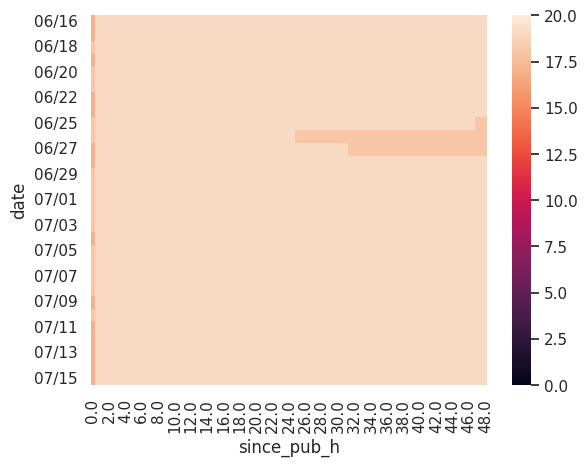

In [49]:

d = pd.pivot(active_nodes, index="date", columns=["since_pub_h"], values="success_att")
display(d)

sns.set()
g = sns.heatmap(d, vmin=0, vmax=20)
plt.show()

In [50]:
# Check the activity of the PR holders from fetch results
query = f"""
select
    v.cid_hash,
    v.pub_time,
    v.ping_round,
    avg(v.since_pub_h) as since_pub_h,
    sum(v.has_records) as keeping_records
from (
    select
        vcm.cid_hash,
        vcm.pub_time,
        pr.ping_round,
        pr.ping_time_since_publication_m / 60 as since_pub_h,
        CASE WHEN pr.has_records = 'true' then 1 else 0 END as has_records
    from valid_cid_mv vcm
    left join ping_results pr on pr.cid_hash = vcm.cid_hash
    where vcm.pub_time > '{init_date}' and vcm.pub_time < '{finish_date}' and pr.ping_round > 0
) as v
group by v.cid_hash, v.pub_time, v.ping_round
order by v.pub_time, v.ping_round;
"""

start = time.time()
df = pd.read_sql_query(sa.text(query), conn)
print(f"query done in {time.time()-start} seconds")

# data proc
df['date'] = df['pub_time'].dt.strftime('%m/%d')
display(df)

query done in 818.607426404953 seconds


,cid_hash,pub_time,ping_round,since_pub_h,keeping_records,date
0,QmNhi3wVJ2A8qkziaA1UshKuGk6hNJkgervGGEUippBPua,2023-06-16 09:13:43.442304,1,0.500904,16,06/16
1,QmNhi3wVJ2A8qkziaA1UshKuGk6hNJkgervGGEUippBPua,2023-06-16 09:13:43.442304,2,1.000883,17,06/16
2,QmNhi3wVJ2A8qkziaA1UshKuGk6hNJkgervGGEUippBPua,2023-06-16 09:13:43.442304,3,1.500916,17,06/16
3,QmNhi3wVJ2A8qkziaA1UshKuGk6hNJkgervGGEUippBPua,2023-06-16 09:13:43.442304,4,2.000965,17,06/16
4,QmNhi3wVJ2A8qkziaA1UshKuGk6hNJkgervGGEUippBPua,2023-06-16 09:13:43.442304,5,2.501856,17,06/16
...,...,...,...,...,...,...
7646214,QmY61FizGyYZWt1jpUYKdAxj2PyNKbQFMyzB7Bxj4hMTX3,2023-07-15 23:59:54.845602,92,46.013909,15,07/15
7646215,QmY61FizGyYZWt1jpUYKdAxj2PyNKbQFMyzB7Bxj4hMTX3,2023-07-15 23:59:54.845602,93,46.513919,15,07/15
7646216,QmY61FizGyYZWt1jpUYKdAxj2PyNKbQFMyzB7Bxj4hMTX3,2023-07-15 23:59:54.845602,94,47.013914,15,07/15
7646217,QmY61FizGyYZWt1jpUYKdAxj2PyNKbQFMyzB7Bxj4hMTX3,2023-07-15 23:59:54.845602,95,47.513883,15,07/15


In [51]:
# mean values
df1 = df.drop(columns=['cid_hash'])
nodes_keeeping = df1.groupby(['date', 'ping_round']).median().reset_index()
nodes_keeeping = nodes_keeeping.drop(columns=['ping_round', 'pub_time'])
display(nodes_keeeping)


,date,since_pub_h,keeping_records
0,06/16,0.501377,17.0
1,06/16,1.001369,17.0
2,06/16,1.501367,17.0
3,06/16,2.001362,17.0
4,06/16,2.501372,17.0
...,...,...,...
2779,07/15,46.001613,15.0
2780,07/15,46.501603,15.0
2781,07/15,47.001586,15.0
2782,07/15,47.501561,15.0


In [52]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Scatter3d(
    z=nodes_keeeping['keeping_records'],
    x=nodes_keeeping['date'],
    y=nodes_keeeping['since_pub_h'],
    mode='markers',
    marker=dict(
        size=5,
        colorscale='Viridis',   # choose a colorscale
        opacity=1.,
        showscale=True,
        cmax=20,
        cmin=0),
    )])

fig.update_layout(
    title="Average PR Holder's keeping PRs",
    autosize=False,
    width=900,
    height=700,
    scene = dict(
        yaxis = dict(nticks=20, range=[0, 50],),
        zaxis = dict(nticks=10, range=[0, 20],),
        xaxis_title='Date',
        yaxis_title='Hours since publication',
        zaxis_title='PR Holders keeping the PRs',
    ),
    margin=dict(
        l=65,
        r=50,
        b=65,
        t=90)
    )
fig.show()

since_pub_h,0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0,...,43.5,44.0,44.5,45.0,45.5,46.0,46.5,47.0,47.5,48.0
date,,,,,,,,,,,,,,,,,,,,,
06/16,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,...,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,14.0
06/17,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,...,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,14.0
06/18,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,...,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,14.0
06/19,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,...,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,14.0
06/20,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,...,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,14.0
06/21,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,...,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,14.0
06/22,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,...,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,13.0
06/24,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,...,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,14.0
06/25,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,...,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,14.0


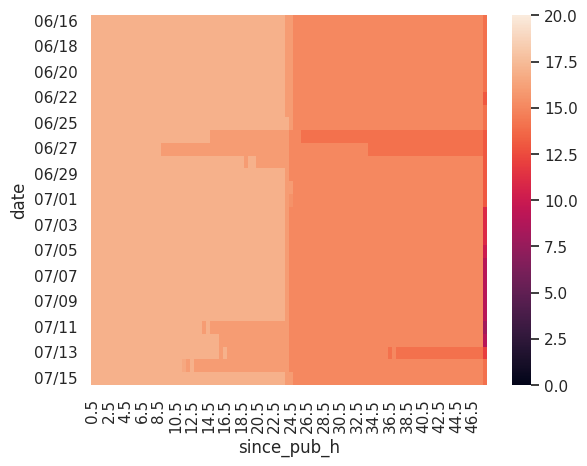

In [53]:
nodes_keeeping["since_pub_m"] = nodes_keeeping['since_pub_h'] * 60
nodes_keeeping["since_pub_h"] = nodes_keeeping['since_pub_m'].astype(int) / 60

d = pd.pivot(nodes_keeeping, index="date", columns=["since_pub_h"], values="keeping_records")
display(d)

sns.set()
g = sns.heatmap(d, vmin=0, vmax=20)
plt.show()